In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cplAE_MET.utils.dataset import  load_MET_dataset, MET_data_summary
from cplAE_MET.utils.load_config import load_config
paths = load_config('config.toml')

/home/rohan/miniconda3/envs/cplae_met/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dat = load_MET_dataset(paths['MET_data'])
isnan = dat['cluster_label']=='nan                             '
dat['cluster_label'][isnan] = 'NA'
dat['cluster_id'][isnan] = np.max(dat['cluster_id']) + 1
dat['cluster_color'][isnan] = '#888888'

#Remove spaces in names
dat['cluster_label'] = np.array(list(map(lambda x: str(x).strip(), dat['cluster_label'])))
dat['cluster_color'] = np.array(list(map(lambda x: str(x).strip(), dat['cluster_color'])))

In [3]:
from pandas.api.types import CategoricalDtype
def order_cat(obs, cat='cluster', by='id'):
    """Order categories in dataframe for easy plotting
    Args:
        obs: ad.obs with columns f'{cat}_label'
        cat (str): 'cluster' or 'subclass'
        by (str): 'id'
    Returns:
        obs
"""
    df = obs.copy()[[f'{cat}_id', f'{cat}_label']]
    df = df.drop_duplicates().sort_values(by=f'{cat}_id')
    df = df.reset_index(drop=True)
    cat_type = CategoricalDtype(categories=df[f'{cat}_label'].to_list(),
                                ordered=True)
    obs[f'{cat}'] = obs[f'{cat}_label'].astype(cat_type)
    return obs, cat_type

In [4]:
df = pd.DataFrame({'cluster_id': dat['cluster_id'],
                  'cluster_label': dat['cluster_label'],
                  'cluster_color': dat['cluster_color']})
df, cats = order_cat(df, cat='cluster')

palette = df.drop_duplicates()
palette = dict(zip(palette['cluster_label'], palette['cluster_color']))


In [5]:
isM = np.sum(np.isnan(dat['XM']).reshape(dat['XM'].shape[0],-1),axis=1)
isM = (isM==0)

isT = np.sum(np.isnan(dat['XT']).reshape(dat['XT'].shape[0],-1),axis=1)
isT = (isT==0)

isE = np.sum(np.isnan(dat['XE']).reshape(dat['XE'].shape[0],-1),axis=1)
isE = (isE==0)

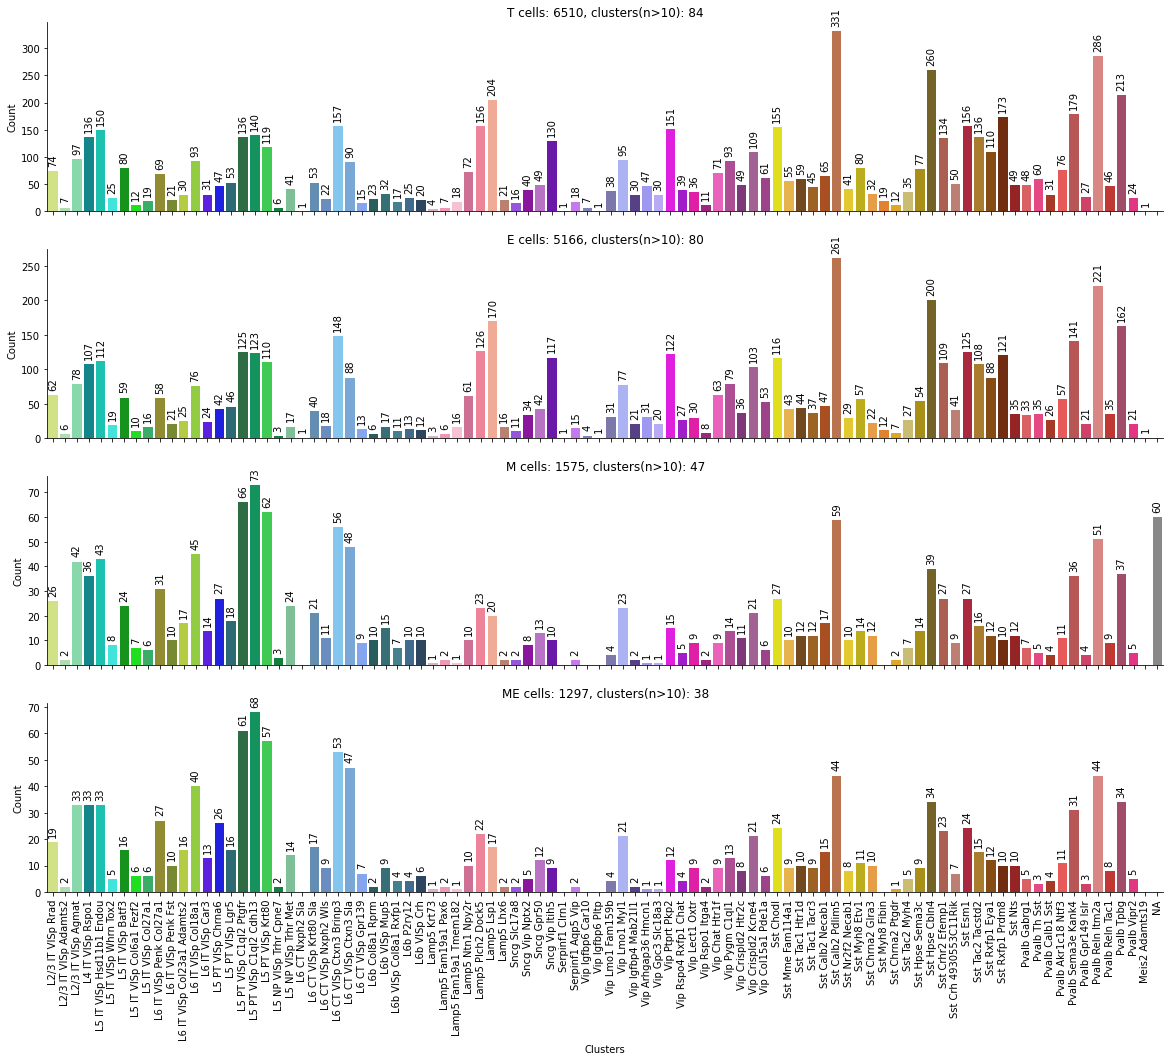

In [6]:
thr = 10


def well_sampled_clusters(bl, thr):
    count = 0
    for b in bl:
        if b.get_text() != '':
            if np.float64(b.get_text()) > thr:
                count = count+1
    return count

f, axs = plt.subplots(4, 1, figsize=(20, 16))
ax = axs[0]
sns.countplot(data=df.loc[isT],
              x='cluster',
              palette=palette,
              ax=ax,
              linewidth=.5)
bl = ax.bar_label(ax.containers[0], padding=5)
[b.set_rotation(90) for b in bl]
n_well_sampled_clusters = well_sampled_clusters(bl, thr)
ax.tick_params(axis='x', labelrotation=90)
ax.set(xlabel='',
       xticklabels=[],
       ylabel='Count',
       title=f'T cells: {np.sum(isT)}, clusters(n>{thr}): {n_well_sampled_clusters}')
sns.despine(ax=ax)

ax = axs[1]
sns.countplot(data=df.loc[isE],
              x='cluster',
              palette=palette,
              ax=ax,
              linewidth=.5)
bl = ax.bar_label(ax.containers[0], padding=5)
[b.set_rotation(90) for b in bl]
n_well_sampled_clusters = well_sampled_clusters(bl, thr)
ax.tick_params(axis='x', labelrotation=90)
ax.set(xlabel='', xticklabels=[], ylabel='Count',
       title=f'E cells: {np.sum(isE)}, clusters(n>{thr}): {n_well_sampled_clusters}')
sns.despine(ax=ax)

ax = axs[2]
sns.countplot(data=df.loc[isM],
              x='cluster',
              palette=palette,
              ax=ax,
              linewidth=.5)
bl = ax.bar_label(ax.containers[0], padding=5)
[b.set_rotation(90) for b in bl]
n_well_sampled_clusters = well_sampled_clusters(bl, thr)
ax.tick_params(axis='x', labelrotation=90)
ax.set(xlabel='', ylabel='Count',
       title=f'M cells: {np.sum(isM)}, clusters(n>{thr}): {n_well_sampled_clusters}', xticklabels=[])
sns.despine(ax=ax)

ax = axs[3]
sns.countplot(data=df.loc[np.logical_and(isM, isE)],
              x='cluster',
              palette=palette,
              ax=ax,
              linewidth=.5)
bl = ax.bar_label(ax.containers[0], padding=5)
[b.set_rotation(90) for b in bl]
n_well_sampled_clusters = well_sampled_clusters(bl, thr)
ax.tick_params(axis='x', labelrotation=90)
ax.set(xlabel='Clusters', ylabel='Count',
       title=f'ME cells: {np.sum(np.logical_and(isM,isE))}, clusters(n>{thr}): {n_well_sampled_clusters}')
sns.despine(ax=ax)
plt.show()
